Using device: cpu
Epoch 1: Train MSE = 0.1097, Test MSE = 0.0870, Train Error = 84.87%, Test Error = 72.89%
Epoch 2: Train MSE = 0.0847, Test MSE = 0.0819, Train Error = 64.63%, Test Error = 56.40%
Epoch 3: Train MSE = 0.0794, Test MSE = 0.0764, Train Error = 50.86%, Test Error = 46.99%
Epoch 4: Train MSE = 0.0741, Test MSE = 0.0715, Train Error = 44.73%, Test Error = 40.66%
Epoch 5: Train MSE = 0.0699, Test MSE = 0.0677, Train Error = 38.71%, Test Error = 36.47%
Epoch 6: Train MSE = 0.0668, Test MSE = 0.0648, Train Error = 34.48%, Test Error = 33.08%
Epoch 7: Train MSE = 0.0644, Test MSE = 0.0628, Train Error = 32.45%, Test Error = 28.90%
Epoch 8: Train MSE = 0.0627, Test MSE = 0.0613, Train Error = 30.52%, Test Error = 27.50%
Epoch 9: Train MSE = 0.0612, Test MSE = 0.0598, Train Error = 29.28%, Test Error = 26.11%
Epoch 10: Train MSE = 0.0599, Test MSE = 0.0584, Train Error = 27.98%, Test Error = 26.16%
Epoch 11: Train MSE = 0.0587, Test MSE = 0.0572, Train Error = 26.96%, Test Error

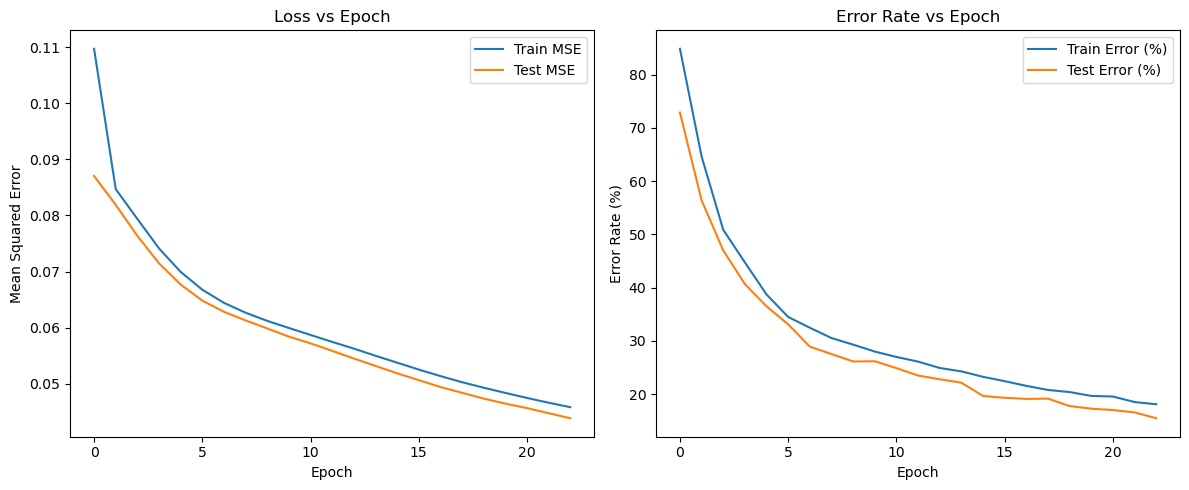

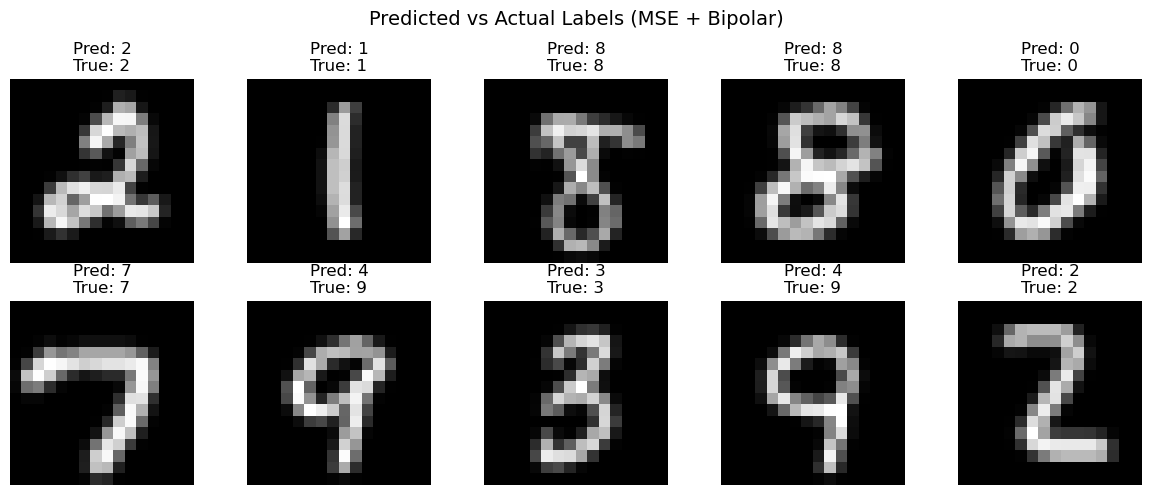

In [1]:
# LeCun1989 Version 2: Using MSELoss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random

# Set seeds and device
torch.manual_seed(1337)
np.random.seed(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Loader
def get_dataloader(split='train', batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((16, 16), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    full_dataset = datasets.MNIST('./data', train=(split == 'train'), download=True, transform=transform)
    n_samples = 7291 if split == 'train' else 2007
    indices = np.random.permutation(len(full_dataset))[:n_samples]
    subset = Subset(full_dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=True), subset

train_loader, train_subset = get_dataloader('train')
test_loader, test_subset = get_dataloader('test')

# Bipolar target converter
def get_bipolar_targets(labels, num_classes=10):
    targets = torch.full((labels.size(0), num_classes), -0.5, device=labels.device)
    targets[torch.arange(labels.size(0)), labels] = 0.5
    return targets

# LeCun1989 Network
class LeCun1989Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5, stride=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(12 * 1 * 1, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model and optimizer
model = LeCun1989Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

# Training and Evaluation
def train_model(model, train_loader, test_loader, epochs=23):
    train_losses, test_losses = [], []
    train_errors, test_errors = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            targets = get_bipolar_targets(labels)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_mse = train_loss / total_train
        train_error = 100 * (1 - correct_train / total_train)

        # Evaluation
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                targets = get_bipolar_targets(labels)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_mse = test_loss / total_test
        test_error = 100 * (1 - correct_test / total_test)

        train_losses.append(train_mse)
        test_losses.append(test_mse)
        train_errors.append(train_error)
        test_errors.append(test_error)

        print(f"Epoch {epoch+1}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}, "
              f"Train Error = {train_error:.2f}%, Test Error = {test_error:.2f}%")

    # Final results
    print("\nFinal Results:")
    print(f"Train Error: {train_errors[-1]:.2f}% ({int(total_train * train_errors[-1] / 100)} misses)")
    print(f"Test Error: {test_errors[-1]:.2f}% ({int(total_test * test_errors[-1] / 100)} misses)")
    print(f"Train MSE: {train_losses[-1]:.4f}")
    print(f"Test MSE: {test_losses[-1]:.4f}")

    return train_losses, test_losses, train_errors, test_errors

# Train
train_losses, test_losses, train_errors, test_errors = train_model(model, train_loader, test_loader)

# Plotting
plt.figure(figsize=(12, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Loss vs Epoch')
plt.legend()

# Error Rate vs Epoch
plt.subplot(1, 2, 2)
plt.plot(train_errors, label='Train Error (%)')
plt.plot(test_errors, label='Test Error (%)')
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction Visualization
model.eval()
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
sample_indices = random.sample(range(len(test_subset)), 10)

for i, ax in enumerate(axs.flat):
    image, label = test_subset[sample_indices[i]]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_input)
        pred = output.argmax(dim=1).item()
    ax.imshow(image.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Pred: {pred}\nTrue: {label}")
    ax.axis('off')

plt.suptitle("Predicted vs Actual Labels (MSE + Bipolar)", fontsize=14)
plt.tight_layout()
plt.show()
